In [1]:
# Libraries import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error

In [2]:
data = pd.read_csv('../data/model-cleaned-players22.csv')

data['value_eur'] = np.log(data['value_eur'])

In [3]:
y = data['value_eur']
x = data.drop(columns= 'value_eur')

x_trai, x_tes, y_train, y_test = train_test_split(
   x, y, test_size=0.2, random_state=0
)

scaler = StandardScaler()
x_train = scaler.fit_transform(x_trai)
x_test = scaler.transform(x_tes)

In [4]:
rfr = RandomForestRegressor(n_estimators=100, random_state=42)
rfr.fit(x_train, y_train)

RandomForestRegressor(random_state=42)

In [5]:
y_pred_train = rfr.predict(x_train)
y_pred_train

array([14.2939014 , 13.51629006, 13.16730019, ..., 14.39583197,
       14.0770744 , 15.68731273])

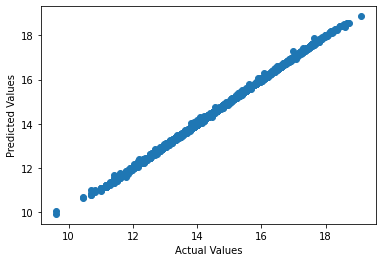

In [6]:
plt.scatter(y_train, y_pred_train)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

In [7]:
train_r2_score = r2_score(y_train, y_pred_train)
train_rmse = mean_squared_error(y_train, y_pred_train, squared=False)

print('Train r2 Score:', train_r2_score)
print('Train RMSE:', train_rmse)

Train r2 Score: 0.9997346864339344
Train RMSE: 0.019517571870289477


In [8]:
y_pred_test = rfr.predict(x_test)
y_pred_test

array([13.11598833, 13.43208465, 14.5814794 , ..., 12.76267296,
       12.80214791, 13.23759719])

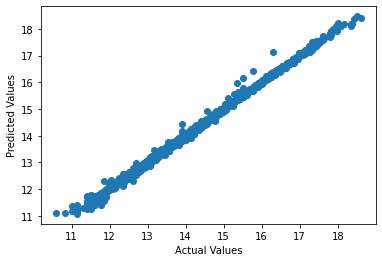

In [9]:
plt.scatter(y_test, y_pred_test)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

In [10]:
test_r2_score = r2_score(y_test, y_pred_test)
test_rmse = mean_squared_error(y_test, y_pred_test, squared=False)

print('Test r2 Score:', test_r2_score)
print('Test RMSE:', test_rmse)

Test r2 Score: 0.9979598105883949
Test RMSE: 0.054114112053845385


In [11]:
train_cross_val_r2_scores = cross_val_score(rfr, x_train, y_train, scoring='r2', cv=10)
train_cross_val_r2_score = np.mean(train_cross_val_r2_scores)

train_cross_val_rmse_scores = cross_val_score(rfr, x_train, y_train, scoring='neg_mean_squared_error', cv=10)
train_cross_val_rmse_score = -np.mean(train_cross_val_rmse_scores)


test_cross_val_r2_scores = cross_val_score(rfr, x_test, y_test, scoring='r2', cv=10)
test_cross_val_r2_score = np.mean(test_cross_val_r2_scores)

test_cross_val_rmse_scores = cross_val_score(rfr, x_test, y_test, scoring='neg_mean_squared_error', cv=10)
test_cross_val_rmse_score = -np.mean(test_cross_val_rmse_scores)


print("Train Cross-Validated R2 Score:", train_cross_val_r2_score)
print("Test Cross-Validated R2 Score:", test_cross_val_r2_score)

print("Train Cross-Validated RMSE:", train_cross_val_rmse_score)
print("Test Cross-Validated RMSE:", test_cross_val_rmse_score)

Train Cross-Validated R2 Score: 0.9979577490582046
Test Cross-Validated R2 Score: 0.9942486850849453
Train Cross-Validated RMSE: 0.0029252036337043693
Test Cross-Validated RMSE: 0.008295357076931593


In [18]:
# Hyperparameter Tuning
params = {
   'n_estimators': [100, 150, 200],
   'max_depth': [None, 10, 20],
   'min_samples_split': [2, 5, 10],
   'min_samples_leaf': [1, 2, 4],
   'max_features': ['auto', 'sqrt', 0.5],
   'bootstrap': [True]
}

grid_search = GridSearchCV(
   rfr,
   params,
   cv=5,
   n_jobs=-1, # This uses all available CPU cores which improves performance
   error_score='raise', # If there's any error, this raises the exact error instead of a more vague error. 
   scoring='r2'
)
grid_search.fit(x_train[:5000], y_train[:5000])

# Get the best hyperparameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Evaluate the best model on the test set
y_pred = best_model.predict(x_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

train_score = best_model.score(x_train, y_train)
test_score = best_model.score(x_test, y_test)

print('r2 score train:', train_score)
print('r2 score test:', test_score)
print('mse:', mse)
print('rmse:', rmse)

r2 score train: 0.9974132695040664
r2 score test: 0.9960120377669264
mse: 0.005724026302314704
rmse: 0.07565729510308113


In [19]:
print(best_params)

{'bootstrap': True, 'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}


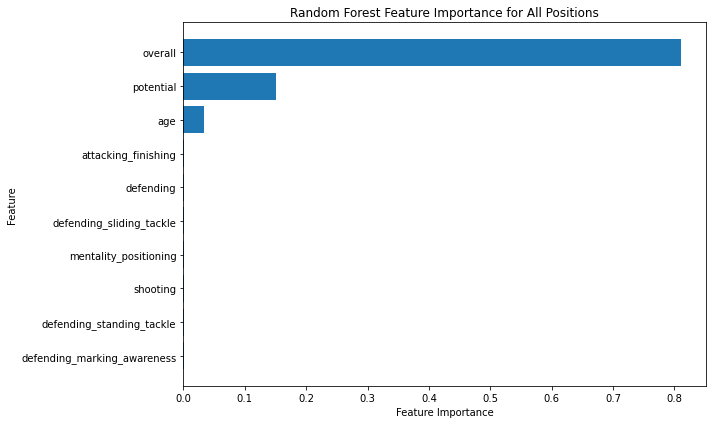

In [20]:
# Feature Importance
def display_feature_importance(model, x_data, chart_title):
   feature_names = list(x_data.columns)
   feature_importances = model.feature_importances_

   # Sort features based on importance
   sorted_indices = np.argsort(feature_importances)[::-1]
   top_10_indices = sorted_indices[:10]
   reversed_top_10_indices = top_10_indices[::-1] # This reverse is needed to make the chart display from the top in descending order
   sorted_importances = feature_importances[reversed_top_10_indices]
   sorted_feature_names = [feature_names[i] for i in reversed_top_10_indices]

   # Plot histogram of feature importances
   plt.figure(figsize=(10, 6))
   plt.barh(range(len(sorted_feature_names)), sorted_importances, align='center')
   plt.yticks(range(len(sorted_feature_names)), sorted_feature_names)
   plt.xlabel('Feature Importance')
   plt.ylabel('Feature')
   plt.title(f'Random Forest Feature Importance for {chart_title}')
   plt.tight_layout()
   plt.show()

display_feature_importance(rfr, x, 'All Positions')

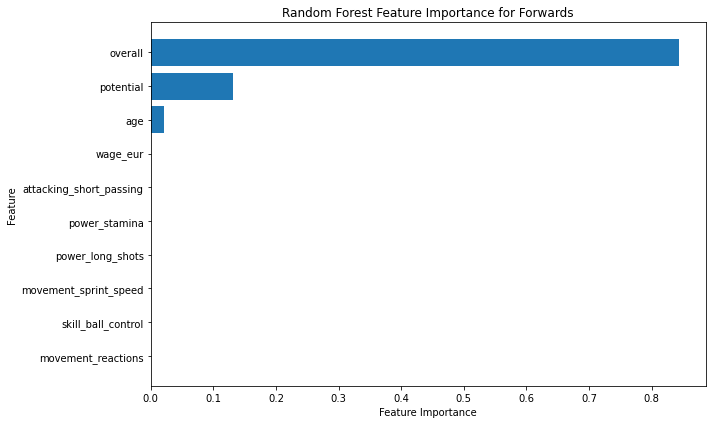

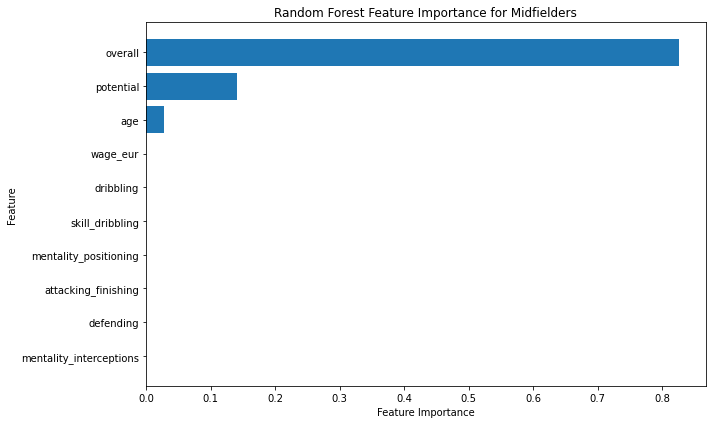

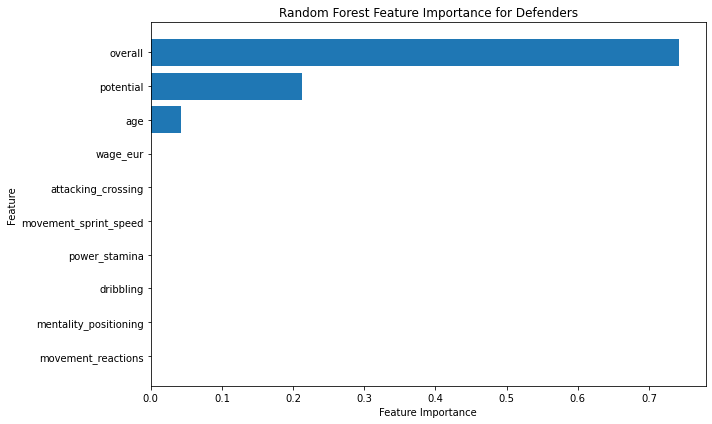

In [21]:
position_mapping = {
   0: 'Defender',
   1: 'Forward',
   2: 'Midfielder'
}

def get_position(position_index: int) -> str:
   try:
      return position_mapping[position_index]
   except KeyError:
      return 'Invalid Position'

# Get unique player positions
unique_positions = x['position'].unique()

# Loop through unique positions and create models and plots
for position in unique_positions:
   position_indices = x[x['position'] == position].index
   position_x = x.loc[position_indices]
   position_y = y[position_indices]

   # Create a Random Forest Regression model for the specific position
   # using the best params gotten from the hyperparameter tuning
   position_rf_model = RandomForestRegressor(
      n_estimators = best_params['n_estimators'],
      random_state = 42,
      bootstrap = best_params['bootstrap'],
      max_depth = best_params['max_depth'],
      max_features = best_params['max_features'],
      min_samples_leaf = best_params['min_samples_leaf'],
      min_samples_split = best_params['min_samples_split']
   )
   position_rf_model.fit(position_x, position_y)

   display_feature_importance(position_rf_model, position_x, f'{get_position(position)}s')